# Privug Covid19 Experiments

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
import numpy as np
import pymc3 as pm
import arviz as az
import glob
import os
import re
import itertools
from numpy import mean,median
from scipy.stats import mode
f=lambda x: mode(x)[0][0]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Auxiliary functions

In [2]:
def get_probs(file_path):
    with open (file_path, 'rt') as myfile:
        text = myfile.read()
    m_x = re.findall(r"\=\s\d\.\d*.*", text)
    return np.array([float(s.replace("= ","")) for s in m_x])


def get_xy(file_path):
    with open (file_path, 'rt') as myfile:
        text = myfile.read()

    m_x = re.search('"x":(.+?)],', text)
    if m_x:
        found_x = m_x.group(1)
    x=[float(i) for i in found_x[1:].split(',')]
    
    m_y = re.search('"y":(.+?)],', text)
    if m_y:
        found_y = m_y.group(1)
    y=[float(i) for i in found_y[1:].split(',')]    
    
    return (x,y)

def get_df_attr_discl(anonymization,prior):
    # this structure is hardcoded...
    # example: results/ano_everything/uniform/50/job.50270.50.out
    file_paths=glob.glob("results/"+anonymization+"/"+prior+"/*/*.out")

    data    = [get_probs(file_path) for file_path in file_paths]
    columns = ["age","age,zip","age,bday","age,sex","age,zip,bday","age,zip,sex","age,zip,bday,sex"]
    rows    = [int(re.search(r"\.\d*\.out", file_path).group(0).replace(".","").replace("out","")) for file_path in file_paths]            
    return pd.DataFrame(data,index=rows,columns=columns).sort_index()

def plot(anonymization,prior,ax,legend=True,fontsize=10):
    get_df_attr_discl(anonymization,prior).T.plot.bar(ax=ax,cmap='winter',rot=17,fontsize=fontsize)
    ax.set_ylim([0,1.1])
    ax.set_title(anonymization+" $\mid$ Prior: "+prior,fontsize=fontsize)
    ax.legend(loc='upper left',fontsize='x-small') if legend else ax.get_legend().remove()
    
    
def plot_qad(x1,x2,y1,y2,ax,cond1=145,cond2=24,upper_bound=50):
    
    y1_non_zero_idxs=np.where(y1>0)
    y2_non_zero_idxs=np.where(y2>0)
    
    # uniform
    cond=cond1
    ax.bar(x1[y1_non_zero_idxs]*100/cond,y1[y1_non_zero_idxs],alpha=.7,label='Uniform', color='cyan')
    
    # covid
    cond=cond2
    ax.bar(x2[y2_non_zero_idxs]*100/cond,y2[y2_non_zero_idxs],alpha=.7,label='Covid19',color='red')
    ax.legend(loc='best')
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[:upper_bound])
    ax.set_xticklabels([str(i)+'\%' for i in ticks][:upper_bound])
    
def plot_qad_1(x1,x2,y1,y2,ax,cond=3,upper_bound=50,color1='steelblue',color2='darkorange'):
    
    y1_non_zero_idxs=np.where(y1>0)
    y2_non_zero_idxs=np.where(y2>0)
    
    # uniform
    ax.bar(x1[y1_non_zero_idxs],y1[y1_non_zero_idxs],alpha=.7,label='{\sc Uniform}',color=color1)
    
    # covid
    ax.bar(x2[y2_non_zero_idxs],y2[y2_non_zero_idxs],alpha=.7,label='{\sc Covid19}',color=color2)
    ax.legend(loc='best')
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[:upper_bound])
    ax.set_xticklabels([str(round(i*100/cond,1))+'\%' for i in ticks][:upper_bound])

## Age and COVID Infections Data

In [3]:
df_f=pd.read_csv('data/ageFemale.csv',sep=';')
df_m=pd.read_csv('data/ageMale.csv',sep=';')
df_covid=pd.read_csv('data/coronaInfected.csv',sep=';')

In [4]:
df_f.head

<bound method NDFrame.head of      Age  Population  AgeShare
0      0       29817  0.010191
1      1       30036  0.010266
2      2       30315  0.010361
3      3       30350  0.010373
4      4       29084  0.009940
..   ...         ...       ...
121  121           0  0.000000
122  122           0  0.000000
123  123           0  0.000000
124  124           0  0.000000
125  125           0  0.000000

[126 rows x 3 columns]>

<ipython-input-5-28de8fb04c99>:24: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('ageDistribution-ageDiagnosis.png', dpi=200, bbox_inches='tight')
<ipython-input-5-28de8fb04c99>:24: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('ageDistribution-ageDiagnosis.png', dpi=200, bbox_inches='tight')
/home/pardo/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


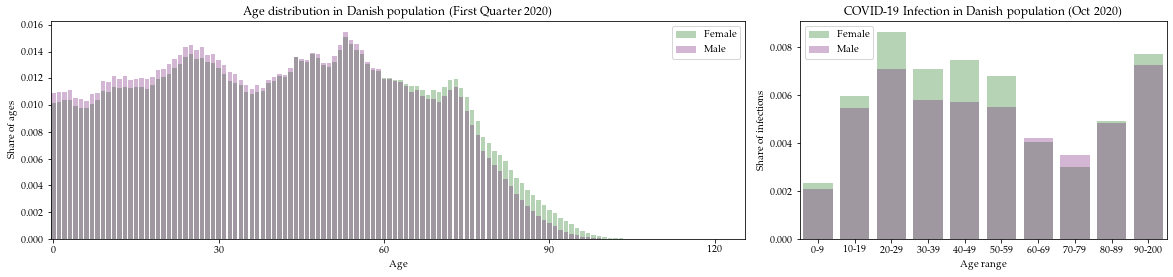

In [5]:
fig=plt.figure(constrained_layout=True,figsize=(20,4))
gs=GridSpec(1,24)
axs0=fig.add_subplot(gs[0:15])
axs1=fig.add_subplot(gs[16:24])

# fig 1
sns.barplot(x=df_f['Age'],y=df_f['AgeShare'],color='green',alpha=0.3,label='Female',ax=axs0)
sns.barplot(x=df_m['Age'],y=df_m['AgeShare'],color='purple',alpha=0.3,label='Male',ax=axs0)
axs0.xaxis.set_major_locator(plt.MaxNLocator(5))
axs0.set_xlabel('Age')
axs0.set_ylabel('Share of ages')
axs0.set_title('Age distribution in Danish population (First Quarter 2020)')
axs0.legend(loc='best')

# fig 2
sns.barplot(x=df_covid['Interval Start'],y=df_covid['FemaleShare'],color='green',alpha=0.3,label='Female',ax=axs1)
sns.barplot(x=df_covid['Interval Start'],y=df_covid['MaleShare'],color='purple',alpha=0.3,label='Male',ax=axs1)
axs1.set_xticklabels([str(i[0])+'-'+str(i[1]) for i in zip(df_covid['Interval Start'],df_covid['Interval End'])])
axs1.set_xlabel('Age$\;$range')
axs1.set_ylabel('Share of infections')
axs1.set_title('COVID-19 Infection in Danish population (Oct 2020)')
axs1.legend(loc='upper left')

plt.savefig('ageDistribution-ageDiagnosis.png', dpi=200, bbox_inches='tight')

## Identity disclosure queries

#### All ages, attr_r, attr_g(age)

/home/pardo/.local/lib/python3.8/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.7490196078431373, 1.0), (0.0, 0.7490196078431373, 1.0), (0.0, 0.7490196078431373, 1.0), (0.0, 0.7490196078431373, 1.0), (0.0, 0.7490196078431373, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/pardo/.local/lib/python3.8/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.8431372549019608, 0.0), (1.0, 0.8431372549019608, 0.0), (1.0, 0.8431372549019608, 0.0), (1.0, 0.8431372549019608, 0.0), (1.0, 0.8431372549019608, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/pardo/.local/lib/python3.8/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgeco

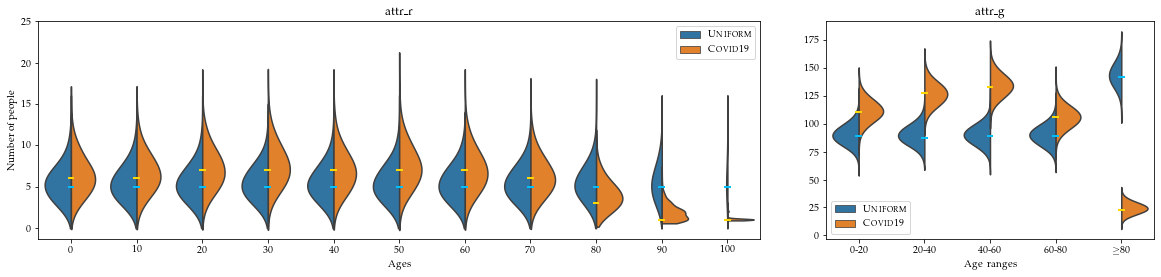

In [6]:
ages_no=[10*i for i in range(0,11)]
yxs4 = np.array([get_xy('results/no_ano/uniform/'+str(i)+'/numgovage.html') for i in ages_no])
yxs5 = np.array([get_xy('results/no_ano/covid/'+str(i)+'/numgovage.html') for i in ages_no])
d2=np.concatenate([np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs4]+[np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs5])
a2=np.concatenate([np.repeat(x,100000) for x in ages_no]+[np.repeat(x,100000) for x in ages_no])
p2=np.concatenate([np.repeat('Uniform',len(ages_no)*100000),np.repeat('Covid',len(ages_no)*100000)])
q2=pd.DataFrame({"# of users": d2, "Ages": a2, "Prior": p2})

ages1=['0-20','20-40','40-60','60-80','$\geq$80']
yxs = np.array([get_xy('results/ano_age/uniform/'+str(i)+'/numgovage.html') for i in [10,30,50,70,90]])
yxs1 = np.array([get_xy('results/ano_age/covid/'+str(i)+'/numgovage.html') for i in [10,30,50,70,90]])
d=np.concatenate([np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs]+[np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs1])
a=np.concatenate([np.repeat(x,100000) for x in ages1]+[np.repeat(x,100000) for x in ages1])
p=np.concatenate([np.repeat('Uniform',len(ages1)*100000),np.repeat('Covid',len(ages1)*100000)])
q=pd.DataFrame({"# of users": d, "Ages": a, "Prior": p})


fig = plt.figure(figsize=(20,4))
gs = fig.add_gridspec(1,3)
ax1 = fig.add_subplot(gs[2])
ax2 = fig.add_subplot(gs[0:2])

sns.violinplot(x="Ages", y="# of users", hue="Prior", data=q, ax=ax1, bw=.5, cut=1, estimator=mode, inner=None, split=True)
sns.violinplot(x="Ages", y="# of users", hue="Prior", data=q2, ax=ax2, bw=.5, cut=1, estimator=mode, inner=None, split=True)


sns.pointplot(x = 'Ages', y='# of users', data=q[q.Prior=='Uniform'], estimator=f, join=False, color='deepskyblue', markers='_', ci=0,ax=ax1)
sns.pointplot(x = 'Ages', y='# of users', data=q[q.Prior=='Covid'],   estimator=f, join=False, color='gold', markers='_', ci=0, ax=ax1)

sns.pointplot(x = 'Ages', y='# of users', data=q2[q2.Prior=='Uniform'], estimator=f, join=False, color='deepskyblue', markers='_', ci=0, ax=ax2)
sns.pointplot(x = 'Ages', y='# of users', data=q2[q2.Prior=='Covid'],   estimator=f, join=False, color='gold', markers='_', ci=0, ax=ax2)

update_legend=lambda L: [t.set_text("{\sc "+t.get_text().replace("Covid","Covid19")+"}") for t in L.get_texts()]

L=ax1.legend(loc='lower left')
update_legend(L)
ax1.set_title('attr\_g')
ax1.set_xlabel('Age~~ranges')
ax1.set_ylabel('')

L=ax2.legend(loc='upper right')
update_legend(L)
ax2.set_ylabel('Number of people')
ax2.set_title('attr\_r')
ax2.set_yticks([i*5 for i in range(0,6)])

plt.savefig("iden-discl-query.pdf",dpi=500,bbox_inches='tight');

#### Complete set of distributions (for all ages) for attr_r

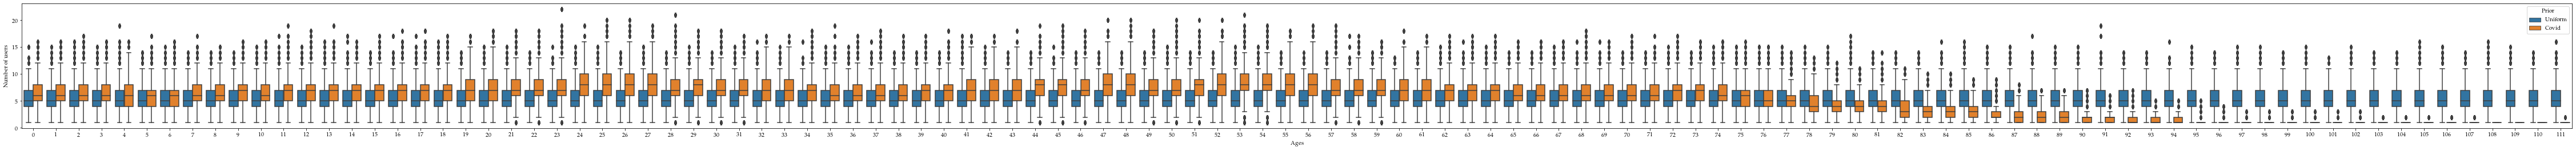

In [8]:
ages2=[str(i) for i in range(0,112)]

yxs2 = np.array([get_xy('results/no_ano/uniform/'+str(i)+'/numgovage.html') for i in range(0,112)])
yxs3 = np.array([get_xy('results/no_ano/covid/'+str(i)+'/numgovage.html') for i in range(0,112)])

d=np.concatenate([np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs2]+[np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs3])
a=np.concatenate([np.repeat(x,100000) for x in ages2]+[np.repeat(x,100000) for x in ages2])
p=np.concatenate([np.repeat('Uniform',len(ages2)*100000),np.repeat('Covid',len(ages2)*100000)])
q1=pd.DataFrame({"Number of users": d, "Ages": a, "Prior": p})

fig, ax = plt.subplots(1,figsize=(80,4))
sns.boxplot(x="Ages", y="Number of users", hue="Prior", data=q1)
plt.savefig("iden-discl-query-no_ano.pdf",dpi=500,bbox_inches='tight');

## Attribute disclosure queries (all anonoymizations, all ages, all priors)

<ipython-input-9-66e56f05c1be>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  [ax.set_yticklabels([str(int(i*100))+"\%" for i in ax.get_yticks()]) for (idx,ax) in zip(range(0,axss.ravel().size),axss.ravel())]


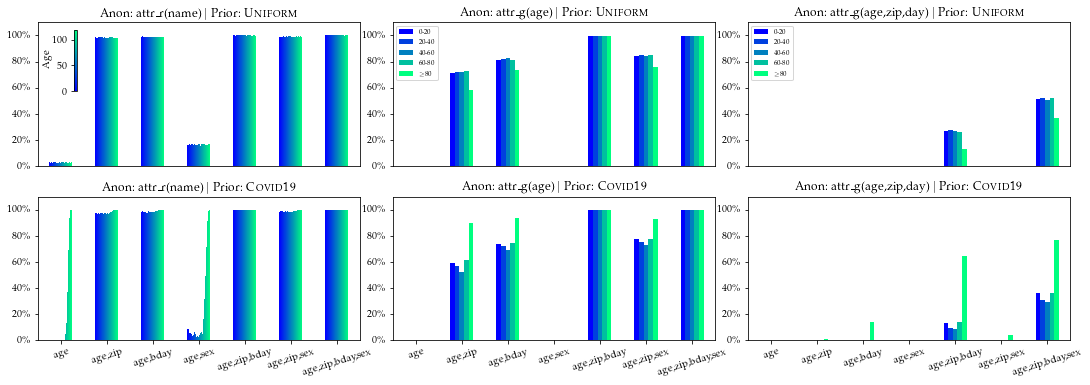

In [9]:
fig, axss = plt.subplots(2,3,figsize=(15,5))
fig.tight_layout(h_pad=1, w_pad=0.7)
plot("no_ano","uniform",axss[0,0],legend=False)
plot("no_ano","covid",axss[1,0],legend=False)
my_cmap = plt.cm.get_cmap('winter')
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,120))
                   #[left, bottom, width, height]
cbaxes=fig.add_axes([0.062, 0.77, 0.003, 0.17])
cbar = plt.colorbar(sm,cax=cbaxes)
cbar.set_label('Age',labelpad=-35)
cbar.ax.yaxis.set_ticks_position('left')

[ plot(anonymization,prior,ax,legend=False) for (ax,(anonymization,prior)) in 
 zip(axss[:,1:].T.ravel(), itertools.product(('ano_age','ano_everything'),('uniform','covid')))];
[ax.set_xticks([]) for ax in axss[0,:].ravel()]
[ax.set_yticklabels([str(int(i*100))+"\%" for i in ax.get_yticks()]) for (idx,ax) in zip(range(0,axss.ravel().size),axss.ravel())]
update_legend=lambda L: [t.set_text(str(int(t.get_text())-10)+"-"+str(int(t.get_text())+10)) if int(t.get_text())!=90 else t.set_text("$\geq$80")  for t in L.get_texts()]
L=axss[0,1].legend(loc='best',fontsize=7)
update_legend(L)
L=axss[0,2].legend(loc='upper left',fontsize=7)
update_legend(L)
[ax.set_title(ax.get_title().replace("no_ano","Anon: attr\_r(name)")
                            .replace("ano_age","Anon: attr\_g(age)")
                            .replace("ano_everything","Anon: attr\_g(age,zip,day)")
                            .replace("covid","{\sc Covid19}")
                            .replace("uniform","{\sc Uniform}")) for ax in axss.ravel()]
plt.savefig("attr-discl-query.pdf", dpi=500, bbox_inches='tight')

## Quantitative attribute disclosure

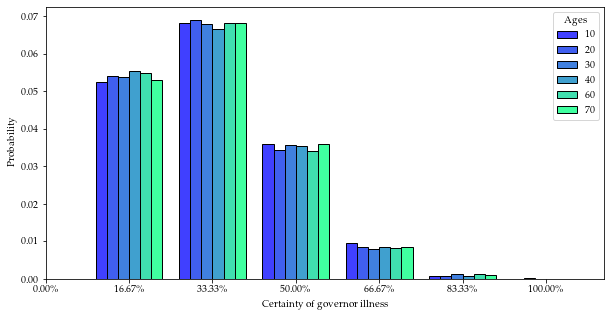

In [10]:
fig,ax=plt.subplots(1,figsize=(10,5))
scenario = 'no_ano_condition_6'
prior    = 'uniform'
ages_t   = [10,20,30,40,60,70]
yxs_1 = np.array([get_xy('results/'+scenario+'/'+prior+'/'+str(i)+'/numgovillage.html') for i in ages_t])


d_t=np.concatenate([np.random.choice(a=x,size=100000,p=y) for (x,y) in yxs_1])
a_t=np.concatenate([np.repeat(x,100000) for x in ages_t])
q_t=pd.DataFrame({"# of users": d_t, "Ages": a_t})
sns.histplot(data=q_t,x="# of users",hue="Ages",stat='probability',
             discrete=True,multiple="dodge",shrink=.8,palette="winter", ax=ax)
plt.xticks(range(0,7),["{:.2f}\%".format(i/6*100) for i in range(0,7)])
plt.xlabel("Certainty of governor illness");

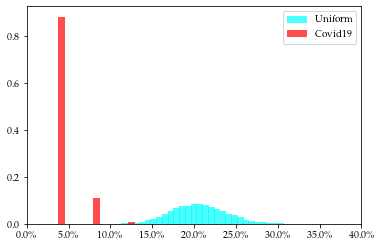

In [11]:
x1,y1=get_xy('results/ano_age_condition_145/uniform/90/numgovillage.html')
x2,y2=get_xy('results/ano_age_condition_24/covid/90/numgovillage.html')

f, ax = plt.subplots()
plot_qad(np.array(x1),np.array(x2),np.array(y1),np.array(y2),ax,cond1=145,cond2=24, upper_bound=50)

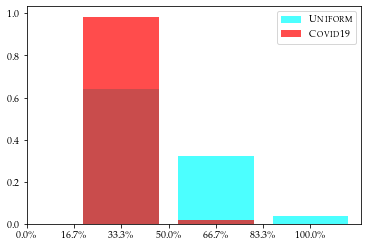

In [12]:
x1,y1=get_xy('results/no_ano_condition_3/uniform/90/numgovillage.html')
x2,y2=get_xy('results/no_ano_condition_3/covid/90/numgovillage.html')

fig,ax=plt.subplots()
plot_qad_1(np.array(x1),np.array(x2),np.array(y1),np.array(y2),ax,cond=3,upper_bound=7,color1='cyan',color2='red')

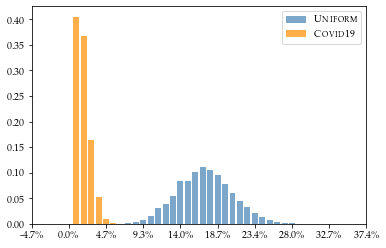

In [13]:
x1,y1=get_xy('results/ano_age_condition_107/uniform/32/numgovillage.html')
x2,y2=get_xy('results/ano_age_condition_107/covid/32/numgovillage.html')

fig,ax=plt.subplots()
plot_qad_1(np.array(x1),np.array(x2),np.array(y1),np.array(y2),ax,cond=107,upper_bound=10)

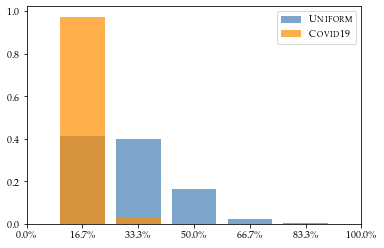

In [14]:
x1,y1=get_xy('results/no_ano_condition_6/uniform/32/numgovillage.html')
x2,y2=get_xy('results/no_ano_condition_6/covid/32/numgovillage.html')

fig,ax=plt.subplots()
plot_qad_1(np.array(x1),np.array(x2),np.array(y1),np.array(y2),ax,cond=6,upper_bound=10)